In [1]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

np.random.seed(1)
ticker = "WFC"

# Open the stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\{ticker}.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

Using TensorFlow backend.
(1006, 13)


In [2]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences)-1:
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 14

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open_ = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open_, high, low, close))
# split sequences
sc = MinMaxScaler()
# d_sc = sc.fit_transform(d)
# X, y = split_sequences(d_sc, n_steps)
X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)

(1000, 4)
(986, 14, 4)
(986, 4)


In [3]:
print(X[-1], y[-1])

[[53.49   53.87   53.3801 53.69  ]
 [53.74   53.98   53.07   53.17  ]
 [53.37   54.55   53.1    54.36  ]
 [54.05   54.42   53.43   53.79  ]
 [54.24   54.56   54.215  54.22  ]
 [54.11   54.51   53.99   54.34  ]
 [54.46   54.46   53.63   53.67  ]
 [53.74   53.83   53.42   53.63  ]
 [54.05   54.05   53.07   53.33  ]
 [53.34   54.     53.25   53.81  ]
 [53.95   54.04   53.735  53.82  ]
 [54.05   54.39   53.95   54.15  ]
 [54.29   54.32   53.865  53.92  ]
 [54.17   54.26   53.5    53.6   ]] [53.53 53.82 53.46 53.8 ]


In [4]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(n_steps, n_features)))#, return_sequences=True, ))
# model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="mae", metrics=["accuracy"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

training_history = model.fit(X_train, y_train, epochs=100, verbose=1)

- 0s 195us/step - loss: 0.4682 - accuracy: 0.9480
Epoch 311/500
788/788 [==============================] - 0s 198us/step - loss: 0.4885 - accuracy: 0.9835
Epoch 312/500
788/788 [==============================] - 0s 194us/step - loss: 0.4525 - accuracy: 0.9759
Epoch 313/500
788/788 [==============================] - 0s 195us/step - loss: 0.4442 - accuracy: 0.9454
Epoch 314/500
788/788 [==============================] - 0s 194us/step - loss: 0.4606 - accuracy: 0.8947
Epoch 315/500
788/788 [==============================] - 0s 206us/step - loss: 0.4371 - accuracy: 0.9683
Epoch 316/500
788/788 [==============================] - 0s 199us/step - loss: 0.4526 - accuracy: 0.9391
Epoch 317/500
788/788 [==============================] - 0s 208us/step - loss: 0.4728 - accuracy: 0.9835
Epoch 318/500
788/788 [==============================] - 0s 195us/step - loss: 0.4804 - accuracy: 0.9074
Epoch 319/500
788/788 [==============================] - 0s 212us/step - loss: 0.4865 - accuracy: 0.8299
Epoch

Text(0.5, 1.0, 'WFC')

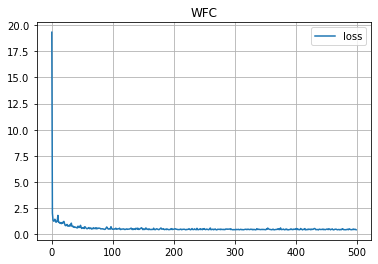

In [5]:
plt.plot(model.history.history["loss"], label="loss")
plt.grid()
plt.legend()
plt.title(ticker)
# plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\losses\\{ticker}.png")

Text(0.5, 1.0, 'WFC')

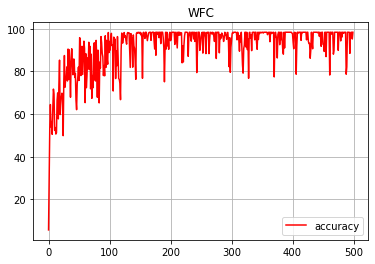

In [6]:
plt.plot(np.array(model.history.history["accuracy"])*100, label="accuracy", color="red")
plt.grid()
plt.legend()
plt.title(ticker)
# plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\accuracies\\{ticker}.png")

In [8]:
mean_accuracy = np.mean(model.history.history["accuracy"])
mean_loss = np.mean(model.history.history["loss"])
print(f"Mean Accuracy: {mean_accuracy}\nMean Loss: {mean_loss}")

Mean Accuracy: 0.9139745831489563
Mean Loss: 0.5775073701330853


In [9]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")
scores

History Item [loss] reports value of 0.38354536017986257
History Item [accuracy] reports value of 0.9696969985961914


[0.38354536017986257, 0.9696969985961914]

In [10]:
actual = y_test[:, -1]
yhat = model.predict(X_test, verbose=0)
yhat.shape
predictions = yhat[:, -1]

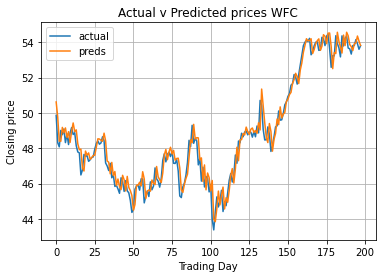

In [11]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price")
plt.xlabel("Trading Day")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
# plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\{ticker}.png")

In [359]:
# with open("scores.csv", "a") as scores_file:
#     scores_file.write(f"{ticker},{mean_loss},{mean_accuracy},{scores[0]},{scores[1]}\n")

(20, 4)


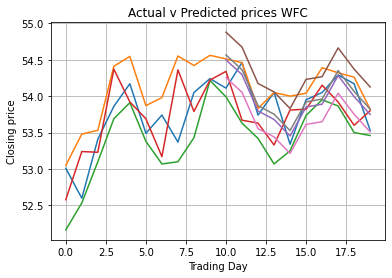

In [12]:
actual = y_test[-20:, :]
X_temp = X_test[-10:]
yhat = model.predict(X_temp, verbose=0)
predictions = np.full(actual.shape, np.NaN)
print(predictions.shape)
predictions[-10:] = yhat[:, :]

fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price"); plt.xlabel("Trading Day")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid(); #plt.legend()